# Background

## Bayesian inference

In [1]:
import signal
import time
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from tqdm.notebook import tqdm, trange
from abcsmc.kernels import UniformKernel, GaussianKernel, MVNKernel, LOCMKernel
from abcsmc.abcsmc import abcsmc
from abcsmc.plotting import plot_results
from abcsmc.models import GaussianModel, RingModel
from abcsmc.priors import UniformPrior, GaussianPrior

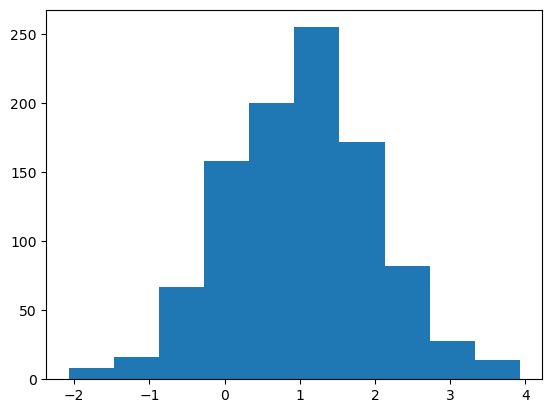

In [2]:
box1 = GaussianModel(1, 1)
data = box1.generate_data(1000)
plt.hist(data);

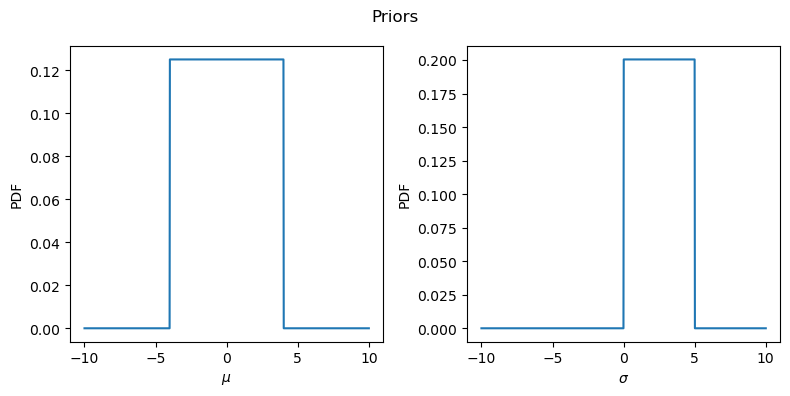

In [3]:
prior_mu = UniformPrior(-4, 4)
prior_sigma = UniformPrior(0.01, 5)

def compute_loglikelihood(x, theta):
    mus = theta[:,0]
    sigmas = theta[:,1]
    ll = -0.5 * ((x[:,None] - mus)/sigmas)**2 - np.log(sigmas) - 0.5*np.log(2*np.pi)
    return np.sum(ll, axis=0)

def compute_logprior(theta):
    mus = theta[:,0]
    sigmas = theta[:,1]
    return np.log(prior_mu.pdf(mus)) + np.log(prior_sigma.pdf(sigmas))

nparticles = 10000
params = np.zeros([nparticles, 2])
params[:,0] = prior_mu.rvs(nparticles)
params[:,1] = prior_sigma.rvs(nparticles)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))

xs = np.linspace(-10, 10, 1000)
ys = prior_mu.pdf(xs)
ax1.plot(xs, ys)

xs = np.linspace(-10, 10, 1000)
ys = prior_sigma.pdf(xs)
ax2.plot(xs, ys)

ax1.set_xlabel('$\mu$')
ax1.set_ylabel('PDF')
ax2.set_xlabel('$\sigma$')
ax2.set_ylabel('PDF')

fig.suptitle('Priors')

plt.tight_layout()

In [4]:
ll = compute_loglikelihood(data, params)
lp = compute_logprior(params)

logposterior = ll + lp

In [5]:
maxidx = np.argmax(logposterior)
mu_amax, sigma_amax = params[maxidx]

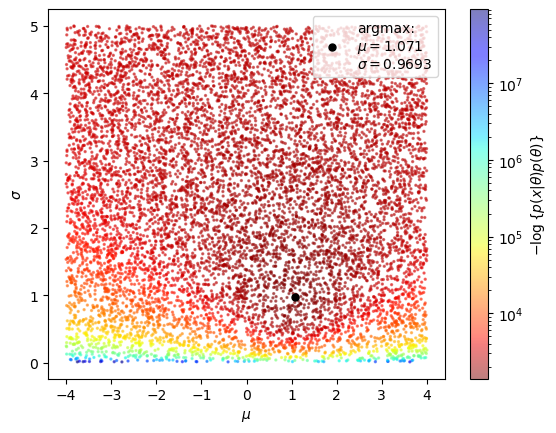

In [6]:
fig, ax = plt.subplots(1, 1)
sc = ax.scatter(
    params[:,0], params[:,1], 
    alpha=0.5,
    c=-logposterior, cmap='jet_r', s=2,
    norm=LogNorm(vmin=-logposterior.max(), vmax=-logposterior.min())
)
ax.plot(
    params[maxidx, 0], params[maxidx, 1], 
    'ok', markersize=5,
    label= f"argmax:\n$\mu={mu_amax:.4g}$\n$\sigma={sigma_amax:.4g}$"
)
ax.set_xlabel("$\mu$")
ax.set_ylabel("$\sigma$")
ax.legend(loc='upper right')
fig.colorbar(sc, ax=ax, label='$-\log\{p(x|\\theta)p(\\theta)\}$');

In [7]:
true_mu = 1
true_sigma = 1
data = GaussianModel(true_mu, true_sigma).generate_data(1000)
data_mu = np.mean(data)
data_var = np.var(data)

prior_mu = UniformPrior(-4, 4)
prior_sigma = UniformPrior(0.01, 5)
prior_list = [prior_mu, prior_sigma]

pname1="$\mu$"
pname2="$\sigma$"

def f_sim(particle, n=100):
    return GaussianModel(particle[0], particle[1]).generate_data(n)

def f_dist(x):
    mu_err = np.abs(np.mean(x) - data_mu) / data_mu
    var_err = np.abs(np.var(x) - data_var) / data_var
    return mu_err + var_err

particles, weights, results_dict = abcsmc(
    nparticles=1000, 
    nparams=2, 
    prior_list=prior_list, 
    niters=5, 
    sim_func=f_sim,
    dist_func=f_dist, 
    eps0=5, 
    eps_percentile=0.15, 
    min_eps=0, 
    kernel_method='locm'
)

particle_history = results_dict['particle_history']
weight_history = results_dict['weight_history']
score_history = results_dict['score_history']
acceptance_rates = results_dict['acceptance_rates']
epsilon_history = results_dict['epsilon_history']
niters = results_dict['niters']


Running ABC-SMC...


Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Current count [Iter 0]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epsilon: 5
Iter 0 finished in 0.119 secs
LOCM Kernel: <dim=2>
Epsilon: 1.441
Iter 1 finished in 0.444 secs
LOCM Kernel: <dim=2>
Epsilon: 0.4652
Iter 2 finished in 0.569 secs
LOCM Kernel: <dim=2>
Epsilon: 0.1518
Iter 3 finished in 1.03 secs
LOCM Kernel: <dim=2>
Epsilon: 0.0584
Iter 4 finished in 4.29 secs


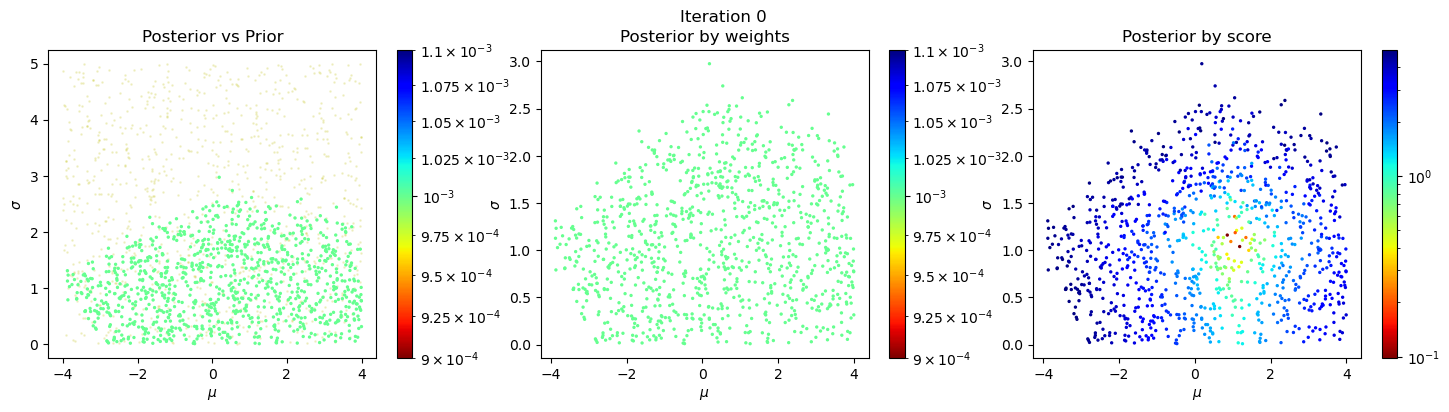

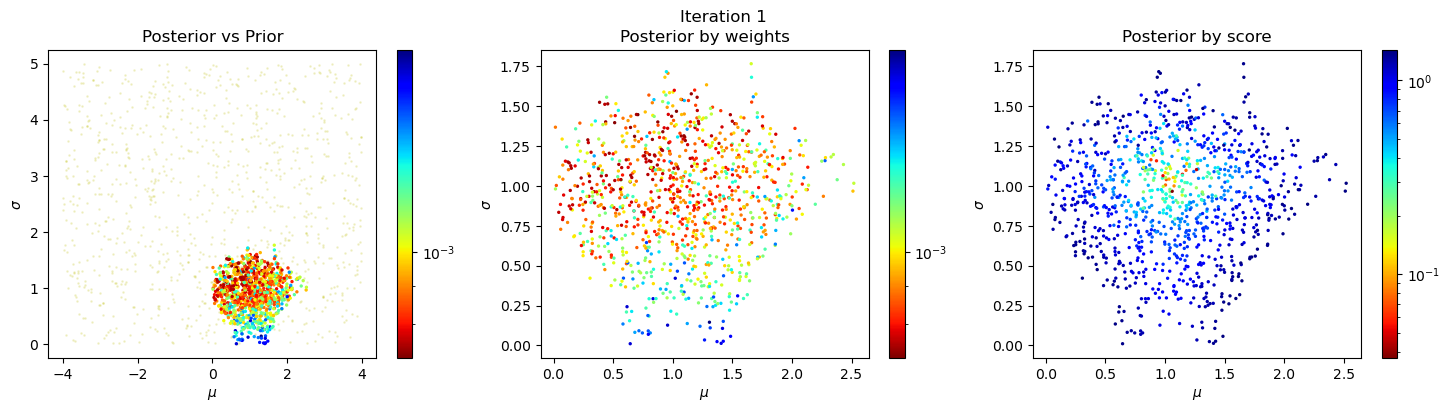

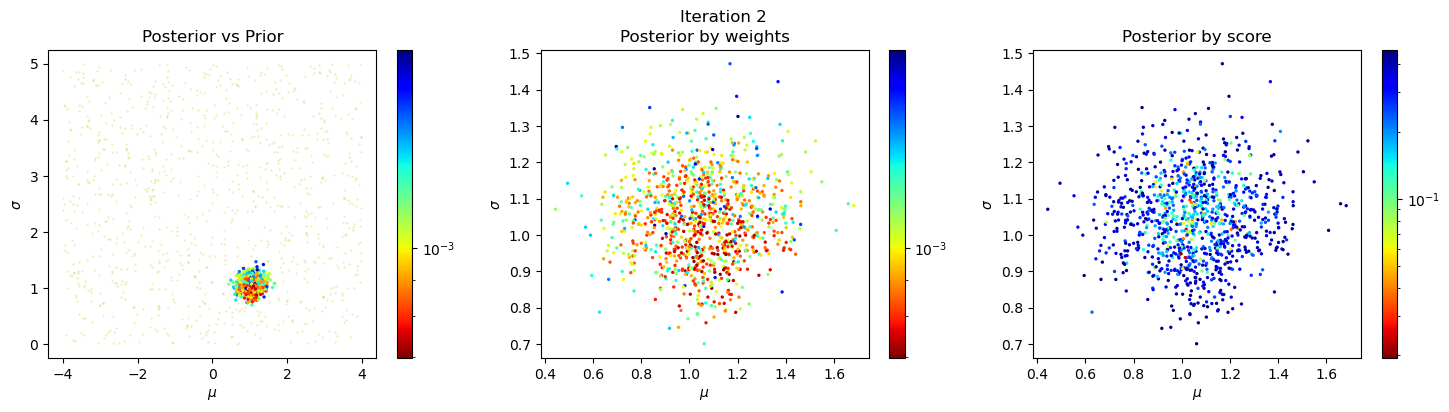

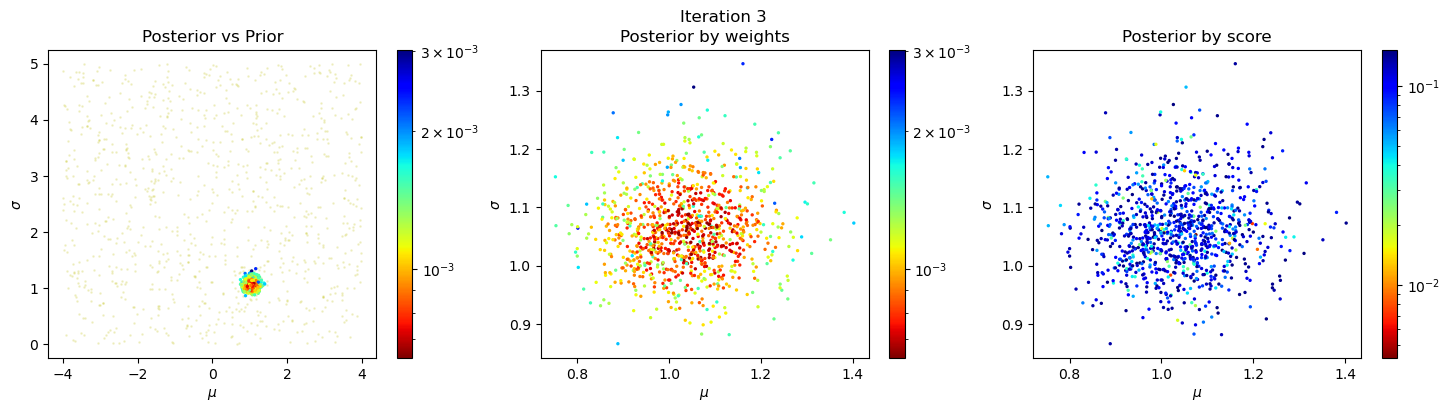

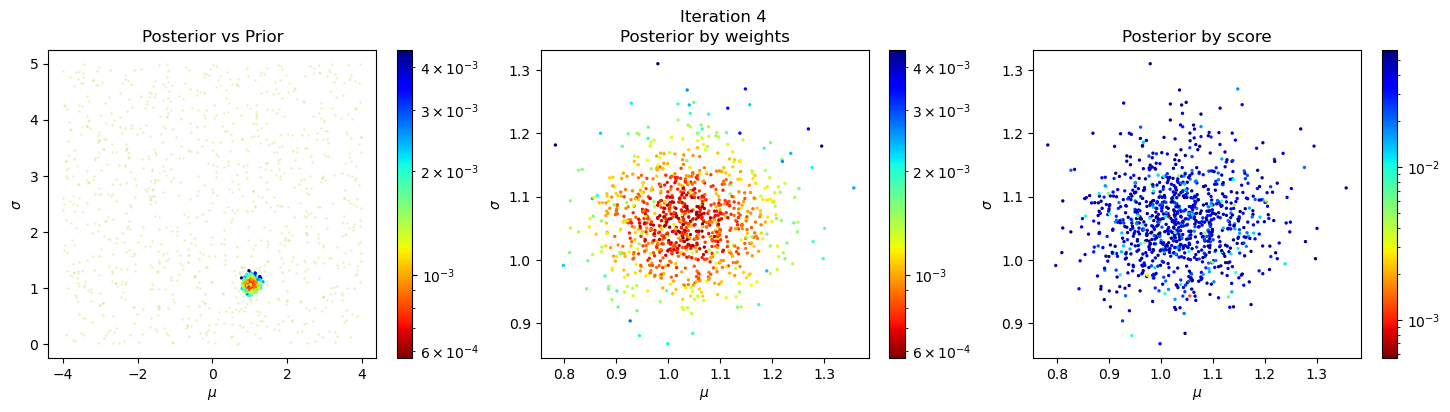

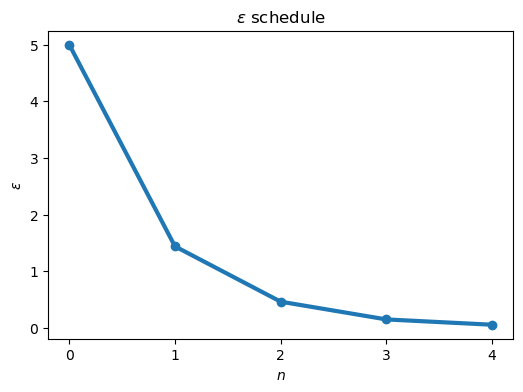

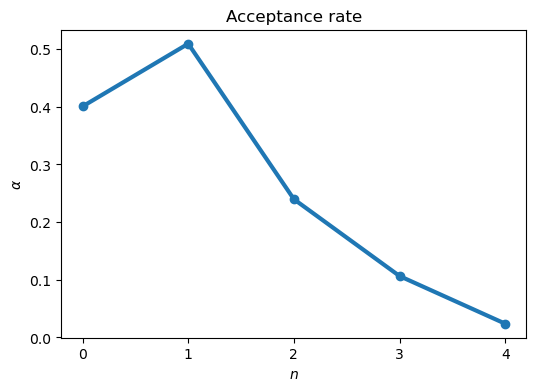

In [8]:
plot_results(
    particle_history, weight_history, score_history, acceptance_rates,
    epsilon_history, prior_list,
    pname1=pname1, pname2=pname2
)

### Ring Example

In [9]:
true_theta1 = 10
true_theta2 = 8
var_const = 0.5
data = RingModel(true_theta1, true_theta2, var_const).generate_data(1000)

data_mu = np.mean(data)
data_var = np.var(data)

prior_theta1 = st.uniform(-50, 100)
prior_theta2 = st.uniform(-50, 100)
prior_list = [prior_theta1, prior_theta2]

def f_sim(particle, n=100):
    return RingModel(particle[0], particle[1], var_const).generate_data(n)

def f_dist(x):
    mu_err = np.abs(np.mean(x) - data_mu) / data_mu
    var_err = np.abs(np.var(x) - data_var) / data_var
    return mu_err + var_err

particles, weights, results_dict = abcsmc(
    nparticles=1000, 
    nparams=2, 
    prior_list=prior_list, 
    niters=5,
    sim_func=f_sim,
    dist_func=f_dist, 
    eps0=5, 
    eps_percentile=0.15, 
    min_eps=0, 
    kernel_method='locm'
)

particle_history = results_dict['particle_history']
weight_history = results_dict['weight_history']
score_history = results_dict['score_history']
acceptance_rates = results_dict['acceptance_rates']
epsilon_history = results_dict['epsilon_history']


Running ABC-SMC...


Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Current count [Iter 0]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epsilon: 5
Iter 0 finished in 0.154 secs
LOCM Kernel: <dim=2>
Epsilon: 0.6007
Iter 1 finished in 0.73 secs
LOCM Kernel: <dim=2>
Epsilon: 0.1662
Iter 2 finished in 3.49 secs
LOCM Kernel: <dim=2>
Epsilon: 0.0624
Iter 3 finished in 21.6 secs
LOCM Kernel: <dim=2>
Epsilon: 0.02423
Caught KeyboardInterrupt Error
Halted during execution of iteration 4/5
Current count: 46/1000
Current epsilon: 0.024231549
Returning previous state (iteration 3).


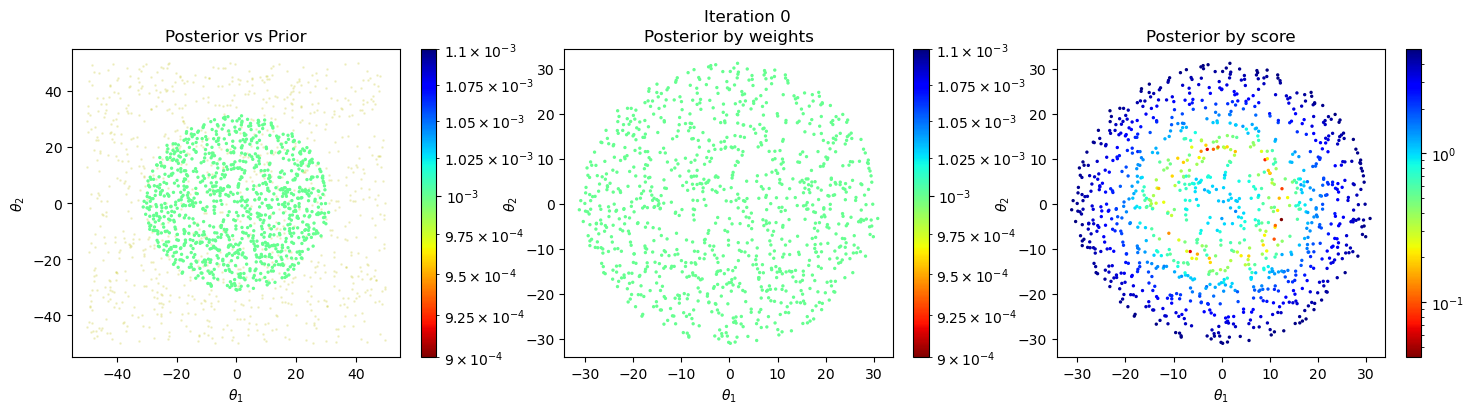

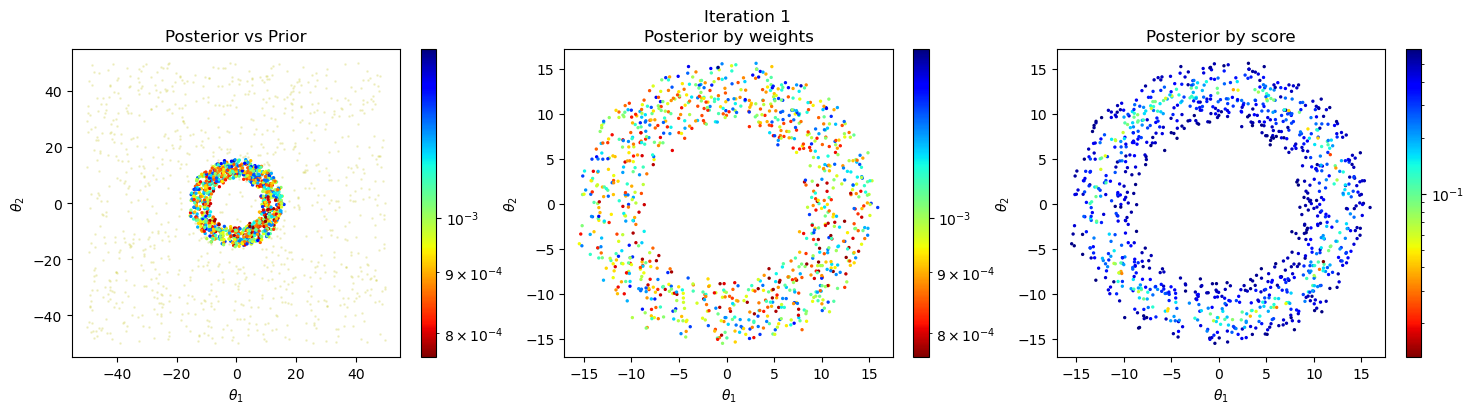

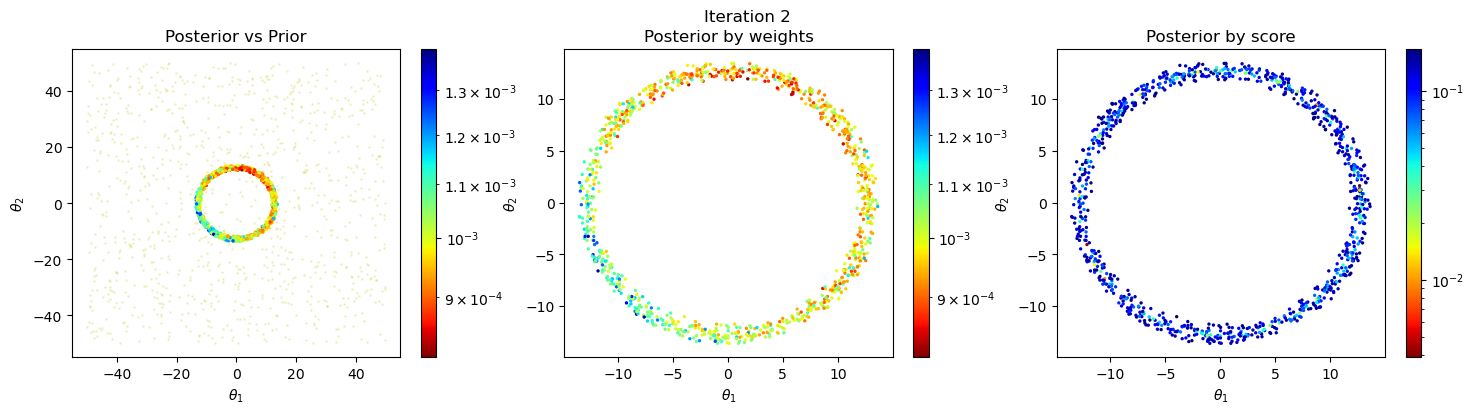

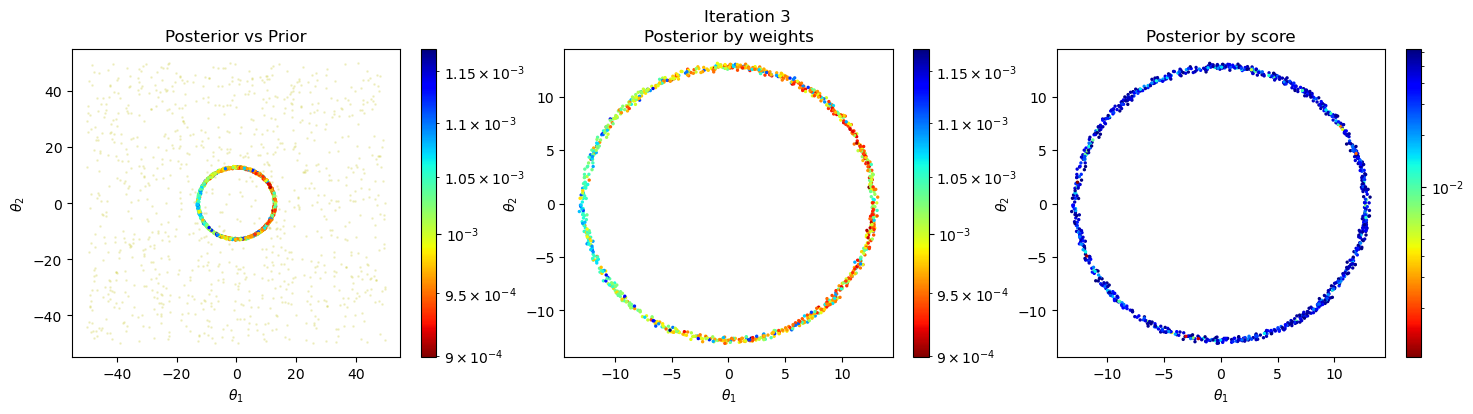

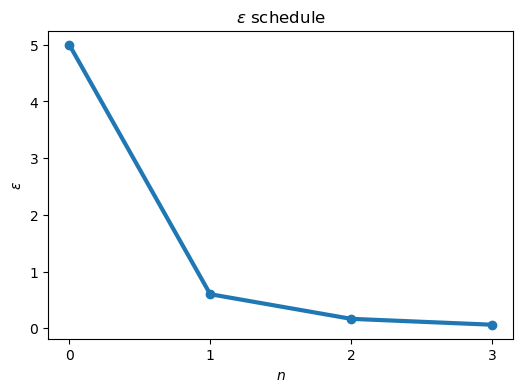

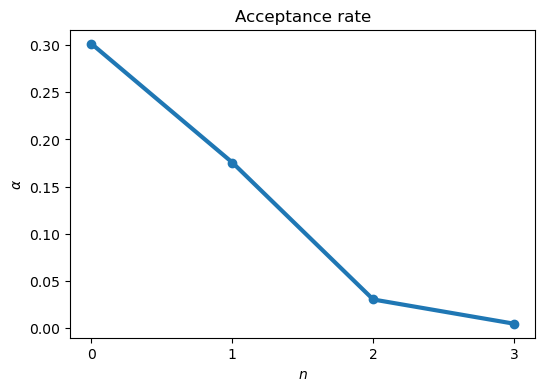

In [10]:
plot_results(
    particle_history, weight_history, score_history, acceptance_rates,
    epsilon_history, prior_list
)

In [ ]:
true_theta1 = 5
true_theta2 = 0
var_const = 0.5
data = RingModel(true_theta1, true_theta2, var_const).generate_data(1)

prior_theta1 = st.uniform(-10, 20)
prior_theta2 = st.uniform(-10, 20)
prior_list = [prior_theta1, prior_theta2]

def f_sim(particle, n=1):
    return RingModel(particle[0], particle[1], var_const).generate_data(n)

def f_dist(x):
    return np.linalg.norm(x - data)

particles, weights, results_dict = abcsmc(
    nparticles=500, 
    nparams=2, 
    prior_list=prior_list, 
    niters=5, 
    sim_func=f_sim,
    dist_func=f_dist, 
    eps0=5, 
    eps_percentile=0.15, 
    min_eps=0, 
    kernel_method='locm',
)

particle_history = results_dict['particle_history']
weight_history = results_dict['weight_history']
score_history = results_dict['score_history']
acceptance_rates = results_dict['acceptance_rates']
epsilon_history = results_dict['epsilon_history']

In [ ]:
plot_results(
    particle_history, weight_history, score_history, acceptance_rates,
    epsilon_history, prior_list
)